# Preraring the data

## Importing packages

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

RANDOM_SEED = 42
TORCH_GEN_SEED = 2147483647

## Loading the data

In [2]:
# Opening the dataset with names and reading its content into a variable
words = open("../names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Building the vocabulary and creating character-number mappings

In [3]:
# Retrieving a set of unique letters
chars = sorted(list(set(''.join(words))))

# Creating a mapping from a letter to an id
char2id = {s: i+1 for i, s in enumerate(chars)}
# Adding the start_of_word/end_of_word token => "."
char2id['.'] = 0

# Creating a mapping from an id to letter
id2char = {i: s for s, i in char2id.items()}

# Computing the size of the vocabulary
vocab_size = len(id2char)

# Displaying the mappings and vocab size
print("Character -> Identifier:")
print(char2id)
print()
print("Identifier -> Character:")
print(id2char)
print()
print(f"Vocabulary size: {vocab_size}")

Character -> Identifier:
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

Identifier -> Character:
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

Vocabulary size: 27


## Splitting the data

In [4]:
# Setting the random seed and reshuffling names
random.seed(RANDOM_SEED)
random.shuffle(words)

# Determining cutoff points for 10% dev and 10% test
cutoff_train = int(0.8*len(words))
cutoff_dev = int(0.9*len(words))

print(f"Training set: {0}-{cutoff_train-1:,}")
print(f"Development set: {cutoff_train:,}-{cutoff_dev-1:,}")
print(f"Testing set: {cutoff_dev:,}-{len(words)-1:,}")

print(f"\nTotal words: {len(words):,}")

Training set: 0-25,625
Development set: 25,626-28,828
Testing set: 28,829-32,032

Total words: 32,033


In [5]:
# Allocating shuffled words into three sets
words_train = words[:cutoff_train]
words_dev = words[cutoff_train:cutoff_dev]
words_test = words[cutoff_dev:]

print(f"Training set examples: {len(words_train):,} ({len(words_train)/len(words):.0%})")
print(f"Development set examples: {len(words_dev):,} ({len(words_dev)/len(words):.0%})")
print(f"Testing set examples: {len(words_test):,} ({len(words_test)/len(words):.0%})")

Training set examples: 25,626 (80%)
Development set examples: 3,203 (10%)
Testing set examples: 3,204 (10%)


In [6]:
def build_dataset(words, block_size):
    # Preallocating lists for dataset
    X, Y = [], []
    for word in words:
        # Creating a starting examples depending on block size
        context = [0] * block_size
        # Iterating through entire word with end of word token
        for char in word + '.':
            index = char2id[char]
            X.append(context)
            Y.append(index)
            # Adding the character index and shifting
            context = context[1:] + [index]
    
    # Casting as PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [7]:
# Setting the block size (number of character to use to predict the next one)
block_size = 3

# Building the datasets for three sets
X_train, Y_train = build_dataset(
    words=words_train, block_size=block_size,
)
X_dev, Y_dev = build_dataset(
    words=words_dev, block_size=block_size,
)
X_test, Y_test = build_dataset(
    words=words_test, block_size=block_size,
)

# One-epoch forward/backward pass runs

## Initialization

In [8]:
# Dimensionality of the character embedding vectors
n_embd = 10

# number of neurons in the hidden layer of the MLP
n_hidden = 64

# Setting up the random numbers generator (for reproducibility)
generator = torch.Generator().manual_seed(TORCH_GEN_SEED)

In [9]:
# Initializing the character embedding matrix
C  = torch.randn((vocab_size, n_embd), generator=generator)

# LAYER 1 WEIGHTS (Kaiming initialization)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=generator)
W1 *= (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=generator) * 0.1

# LAYER 2 WEIGHTS
W2 = torch.randn((n_hidden, vocab_size), generator=generator) * 0.1
b2 = torch.randn(vocab_size, generator=generator) * 0.1

# BATCHNORM LAYER PARAMETERS
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

In [10]:
# Putting all trainable parameters together
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# Computing the number of parameters
num_params = sum(p.nelement() for p in parameters)
print(f"Number of trainable parameters: {num_params:,}") # number of parameters in total

# Making all parameters trainable (enabling gradient computation)
for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 4,137


## Selecting minibatch

In [11]:
# Setting batch size
batch_size = 32
n = batch_size

# Constructing a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
Xb, Yb = X_train[ix], Y_train[ix]

## Forward pass

In [12]:
# Embedding the characters into vectors
emb = C[Xb]
# Concatenating the vectors
embcat = emb.view(emb.shape[0], -1)

#################################################

# LINEAR LAYER 1

# Hidden layer pre-activation
hprebn = embcat @ W1 + b1

#################################################

# BATCHNORM LAYER

bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

#################################################

# TANH LAYER
h = torch.tanh(hpreact)

#################################################

# LINEAR LAYER 2

# Output layer
logits = h @ W2 + b2 # output layer

#################################################

# CROSS-ENTROPY LOSS

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

## Backward pass (Pytorch)

In [13]:
# Zeroing all gradients
for p in parameters:
    p.grad = None
    
# Computing gradients for each element of the computational graph
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()

loss

tensor(3.3475, grad_fn=<NegBackward0>)

We have to now list all manually computed gradients we obtained in Exercise 1 since it will be necessary when making the final comparison.

In [14]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

In [15]:
def cmp(s, dt, t):
    """Compares manual gradients to Pytorch gradients."""
    # Returning True if all gradients are exactly equal
    ex = torch.all(dt == t.grad).item()
    # Returning True if all gradients are approximately equal
    app = torch.allclose(dt, t.grad)
    # Computing the maximum difference between gradients
    maxdiff = (dt - t.grad).abs().max().item()
    # Printing the comparison information
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [16]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

# Exercise 3: Backpropagating through batchnorm (at once)

Let's write down the mathematical representation of the batchnorm layer:

$$\mu = \frac{1}{m} \sum_i x_i$$

$$\sigma^2 = \frac{1}{m - 1} \sum_i (x_i - \mu)^2$$

$$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$$

$$y_i = \gamma \hat{x}_i + \beta$$

We can represent the computations happening inside this layer via the following graph:

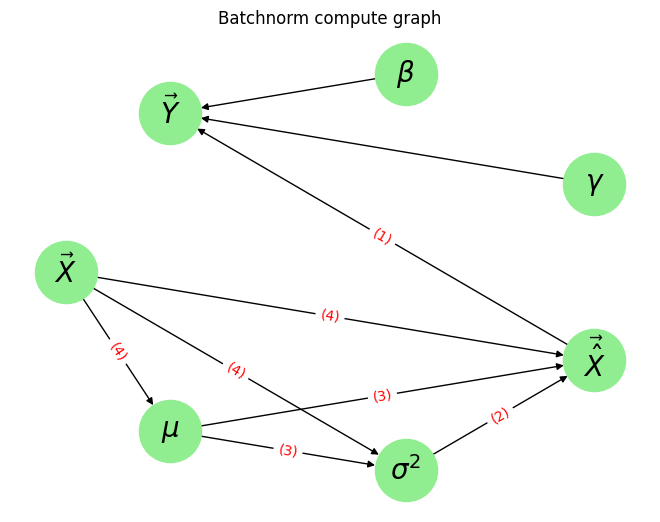

In [17]:
adjacency = {
    r'$\vec{X}$': [r'$\mu$', r'$\sigma^{2}$', r'$\vec{\hat{X}}$'], 
    r'$\mu$': [r'$\vec{\hat{X}}$', r'$\sigma^{2}$'], 
    r'$\sigma^{2}$': [r'$\vec{\hat{X}}$'], 
    r'$\vec{\hat{X}}$': [r'$\vec{Y}$'], 
    r'$\gamma$': [r'$\vec{Y}$'],
    r'$\beta$': [r'$\vec{Y}$'],
}

G = nx.DiGraph(adjacency)
pos = nx.shell_layout(G)
nx.draw(
    G, 
    pos, 
    ax = None, 
    with_labels = True, 
    font_size = 20, 
    node_size = 2000, 
    node_color = 'lightgreen'
)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={
        (r'$\vec{\hat{X}}$', r'$\vec{Y}$'): '(1)',
        (r'$\sigma^{2}$', r'$\vec{\hat{X}}$'): '(2)',
        (r'$\mu$', r'$\vec{\hat{X}}$'): '(3)',
        (r'$\mu$', r'$\sigma^{2}$'): '(3)',
        (r'$\vec{X}$', r'$\vec{\hat{X}}$'): '(4)',
        (r'$\vec{X}$', r'$\sigma^{2}$'): '(4)',
        (r'$\vec{X}$', r'$\mu$'): '(4)',
    },
    font_color='red'
)
plt.title("Batchnorm compute graph")
plt.show()

I denoted vectors with many elements with arrows, while other nodes refer to individual scalars. 

## (1) dloss/dxi_hat

$$\frac{\partial{loss}}{\partial{\hat{x}_i}} = \frac{\partial{loss}}{\partial{y_i}} \frac{\partial{y_i}}{\partial{\hat{x}_i}} = \frac{\partial{loss}}{\partial{y_i}} \gamma$$

## (2) dloss/dsigma2

Since there are many elements in $\hat{x}$, when computing the derivative we have to actually take the sum over all possible paths from $\sigma^2$ to $\hat{x}$. This is due to the fact that $\sigma^2$ here is a single scalar and there are actually lots of arrows going to all the $\hat{x}_i$. 

$$\frac{\partial{loss}}{\partial{\sigma^2}} = \sum_i \frac{\partial{loss}}{\partial{\hat{x}_i}} \frac{\partial{\hat{x}_i}}{\partial{\sigma^2}}$$

$$\frac{\partial{loss}}{\partial{\sigma^2}} = \gamma \sum_i \frac{\partial{loss}}{\partial{y_i}} \frac{\partial}{\partial{\sigma^2}} \left[(x_i - \mu) (\sigma^2 + \epsilon)^{-1/2}\right]$$

$$\frac{\partial{loss}}{\partial{\sigma^2}} = -\frac{1}{2} \gamma \sum_i \frac{\partial{loss}}{\partial{y_i}} (x_i - \mu) (\sigma^2 + \epsilon)^{-3/2}$$

## (3) dloss/dmu

$$\frac{\partial{loss}}{\partial{\mu}} = \sum_i \frac{\partial{loss}}{\partial{\hat{x}_i}} \frac{\partial{\hat{x}_i}}{\partial{\mu}} + \frac{\partial{loss}}{\partial{\sigma^2}} \frac{\partial{\sigma^2}}{\partial{\mu}}$$

$$\frac{\partial{\hat{x}_i}}{\partial{\mu}} = \frac{\partial}{\partial{\mu}} \left[ \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}\right] = -(\sigma^2 + \epsilon)^{-1/2}$$

$$\frac{\partial{\sigma^2}}{\partial{\mu}} = \frac{\partial}{\partial{\mu}} \left[ \frac{1}{m - 1} \sum_i (x_i - \mu)^2\right]$$

$$\frac{\partial{\sigma^2}}{\partial{\mu}} = -\frac{2}{m - 1} \sum_i (x_i - \mu) = -\frac{2}{m - 1} \left(\sum_i x_i - \sum_i \mu \right) = -\frac{2}{m - 1} (m \mu - m \mu) = 0$$

$$\Downarrow$$

$$\frac{\partial{loss}}{\partial{\mu}} = - \sum_i \frac{\partial{loss}}{\partial{y_i}} \gamma (\sigma^2 + \epsilon)^{-1/2}$$

## (4) dloss/dxi

$$\frac{\partial{loss}}{\partial{x}_i} = \frac{\partial{loss}}{\partial{\hat{x}_i}} \frac{\partial{\hat{x}_i}}{\partial{x_i}} + \frac{\partial{loss}}{\partial{\mu}} \frac{\partial{\mu}}{\partial{x_i}} + \frac{\partial{loss}}{\partial{\sigma^2}} \frac{\partial{\sigma^2}}{\partial{x_i}}$$

$$\frac{\partial{\hat{x_i}}}{\partial{x_i}} = (\sigma^2 + \epsilon)^{-1/2}$$

$$\frac{\partial{\mu}}{\partial{x_i}} = \frac{1}{m}$$

$$\frac{\partial{\sigma^2}}{\partial{x_i}} = \frac{2}{m - 1} (x_i - \mu)$$

Now we can plug in everything we have computed into the formula. It should be noted that under the summation we are using a different letter - $j$. This is due to the fact that now in these nodes we are in fact using a different local variable (iterator) which is different from $i$.

$$\frac{\partial{loss}}{\partial{x_i}} = \frac{\partial{loss}}{\partial{y_i}} \gamma (\sigma^2 + \epsilon)^{-1/2} + \left(-\sum_{j} \frac{\partial{loss}}{\partial{y_j}} \gamma (\sigma^2 + \epsilon)^{-1/2}\right) \frac{1}{m} + \left(-\frac{1}{2} \gamma \sum_{j} \frac{\partial{loss}}{\partial{y_j}} (x_j - \mu) (\sigma^2 + \epsilon)^{-3/2}\right) \left(\frac{2}{m - 1} (x_i - \mu)\right)$$

$$\frac{\partial{loss}}{\partial{x_i}} = (\sigma^2 + \epsilon)^{-1/2} \left(\frac{\partial{loss}}{\partial{y_i}} \gamma\right) + (\sigma^2 + \epsilon)^{-1/2} \left(-\frac{1}{m} \sum_{j} \frac{\partial{loss}}{\partial{y_j}} \gamma\right) + (\sigma^2 + \epsilon)^{-1/2} \left(-\gamma \sum_{j} \frac{\partial{loss}}{\partial{y_j}} \frac{x_j - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) \left(\frac{1}{m - 1} \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \right)$$

Using the fact that $\hat{x}_j = \frac{x_j - \mu}{\sqrt{\sigma^2 + \epsilon}}$, we get the following:

$$\frac{\partial{loss}}{\partial{x_i}} = (\sigma^2 + \epsilon)^{-1/2} \left(\frac{\partial{loss}}{\partial{y_i}} \gamma\right) + (\sigma^2 + \epsilon)^{-1/2} \left(-\frac{1}{m} \sum_{j} \frac{\partial{loss}}{\partial{y_j}} \gamma\right) + (\sigma^2 + \epsilon)^{-1/2} \left(-\gamma \sum_{j} \frac{\partial{loss}}{\partial{y_j}} \hat{x}_j \right) \left(\frac{1}{m - 1} \hat{x}_i \right)$$

Rearranging the terms we achieve:

$$\frac{\partial{loss}}{\partial{x_i}} = \frac{\gamma (\sigma^2 + \epsilon)^{-1/2}}{m} \left[m \frac{\partial{loss}}{\partial{y_i}} - \sum_{j} \frac{\partial{loss}}{\partial{y_j}} - \frac{m}{m - 1} \hat{x}_i \sum_{j} \frac{\partial{loss}}{\partial{y_j}} \hat{x}_j \right]$$

In [18]:
# Computing the batchnorm layer pre-activation output
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias

# Verifying the calculations accuracy
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


Now we have to remember that the result obtained is actually valid only for $i$-th example. The result for all the examples is as follows:

In [19]:
# Computing "dloss/dhprebn"
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - (n/(n - 1)) * bnraw * (dhpreact * bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [20]:
hprebn.grad

tensor([[-3.1025e-04, -8.4169e-04,  1.0243e-03,  ..., -2.1567e-04,
         -8.1702e-04, -8.2894e-04],
        [-1.3621e-04,  1.9076e-03,  4.3757e-04,  ...,  5.6336e-04,
         -2.2792e-03, -2.3008e-03],
        [ 2.1828e-04,  2.0248e-03,  5.6559e-04,  ...,  2.7925e-03,
         -7.0843e-05,  5.5493e-04],
        ...,
        [-7.7563e-04,  2.0592e-03, -1.0180e-03,  ..., -2.3206e-03,
         -1.9440e-03, -1.3700e-03],
        [-5.6938e-04,  1.0506e-04, -1.1283e-03,  ...,  1.8434e-04,
          3.0653e-04,  1.1022e-03],
        [-1.2449e-04,  4.2053e-03,  2.5430e-03,  ..., -7.7906e-04,
          4.3721e-04,  6.4878e-04]])

In [21]:
dhprebn

tensor([[-3.1025e-04, -8.4169e-04,  1.0243e-03,  ..., -2.1567e-04,
         -8.1702e-04, -8.2894e-04],
        [-1.3621e-04,  1.9076e-03,  4.3757e-04,  ...,  5.6336e-04,
         -2.2792e-03, -2.3008e-03],
        [ 2.1828e-04,  2.0248e-03,  5.6559e-04,  ...,  2.7925e-03,
         -7.0843e-05,  5.5493e-04],
        ...,
        [-7.7563e-04,  2.0592e-03, -1.0180e-03,  ..., -2.3206e-03,
         -1.9440e-03, -1.3700e-03],
        [-5.6938e-04,  1.0506e-04, -1.1283e-03,  ...,  1.8434e-04,
          3.0653e-04,  1.1022e-03],
        [-1.2449e-04,  4.2053e-03,  2.5430e-03,  ..., -7.7906e-04,
          4.3721e-04,  6.4878e-04]], grad_fn=<MulBackward0>)